# Load Data

In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
filepaths = glob.glob("../data/tidy/albumin/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

In [4]:
df_daily = df.resample("D").count()[["EVENT_ID"]]
df_daily.columns = ["Doses"]

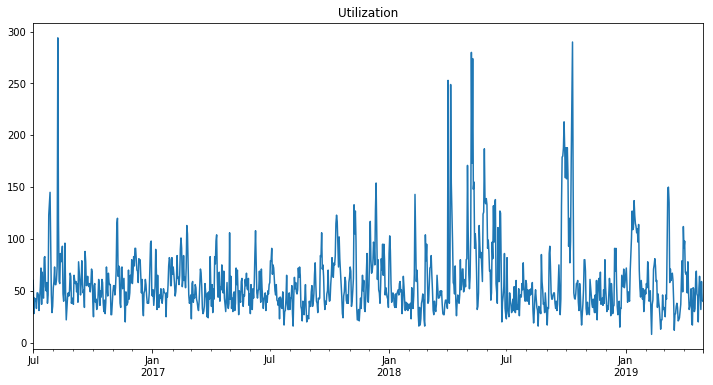

In [5]:
ax = df_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

# ACF

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

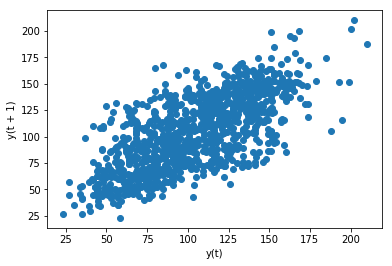

In [6]:
lag_plot(df_daily["Doses"]);

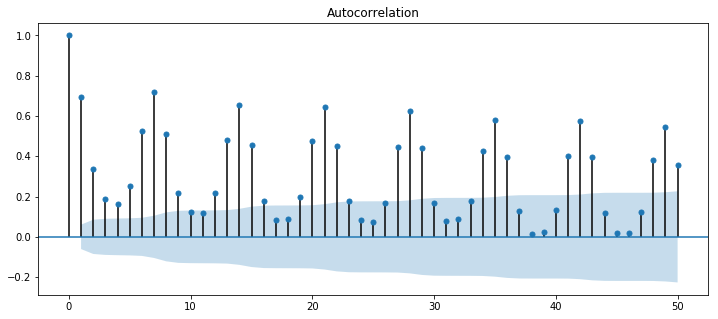

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

plot_acf(df_daily["Doses"], lags=50, ax=ax);
#plot_acf(df_daily);

In [8]:
# data is not stationary; p-value > 0.05
adfuller(df_daily["Doses"].dropna(), autolag='AIC')[1]

0.2978121675515909

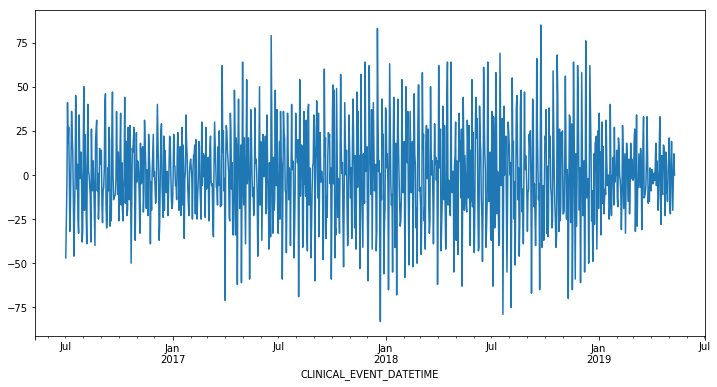

In [9]:
# difference the data to make it stationary
df_diff = df_daily.copy()
df_diff["Doses"] = diff(df_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [10]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

3.674029188920869e-19

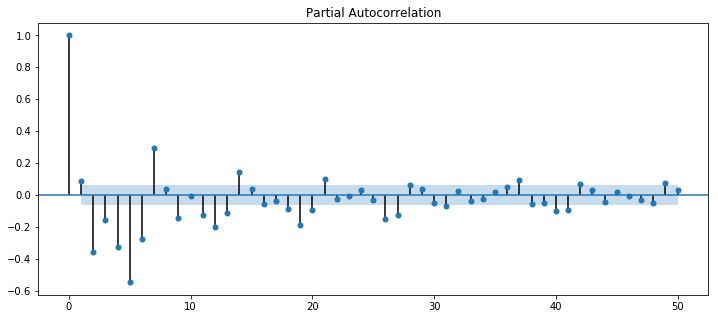

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

# MLP

In [6]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

Using TensorFlow backend.


In [7]:
n_inputs = 60
n_features = 1
n_valid = 7
n_pred = 30
batch_size = 32

In [8]:
df = df_daily
#df = df_diff.dropna()
l = len(df) - n_pred
train_set = df.iloc[:l]
train = df.iloc[:l - n_valid]
valid = df.iloc[l - n_inputs - n_valid:l]
test_set = df.iloc[l:]

In [9]:
gen_train = TimeseriesGenerator(train["Doses"], train["Doses"], length=n_inputs, batch_size=batch_size)

In [10]:
gen_valid = TimeseriesGenerator(valid["Doses"], valid["Doses"], length=n_inputs, batch_size=batch_size)

In [11]:
#for i in range(len(gen_valid)):
#    x, y = gen_valid[i]
#    print('%s => %s' % (x, y))

In [12]:
n_nodes = int(len(df_daily) / (2 * (n_inputs + n_features)))
n_nodes

8

In [13]:
#n_nodes = int(2/3 * (n_inputs + n_features))
#n_nodes

In [14]:
model = Sequential()
model.add(Dense(n_nodes, activation="relu", input_dim=n_inputs))
model.add(Dense(n_nodes, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 488       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 569
Trainable params: 569
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.fit_generator(gen_train, epochs=100, validation_data=gen_valid)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
30/30 [==============================] - 3s 93ms/step - loss: 8198.0872 - val_loss: 1870.1620
Epoch 2/100
30/30 [==============================] - 0s 15ms/step - loss: 2288.4438 - val_loss: 2245.2993
Epoch 3/100
30/30 [==============================] - 1s 23ms/step - loss: 1981.5008 - val_loss: 2082.0945
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 1834.9113 - val_loss: 2074.3677
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 1746.7779 - val_loss: 2082.0188
Epoch 6/100
30/30 [==============================] - 1s 21ms/step - loss: 1625.6313 - val_loss: 1810.6292
Epoch 7/100
30/30 [==============================] - 1s 22ms/step - loss: 1537.2154 - val_loss: 1555.4362
Epoch 8/100
30/30 [==============================] - 1s 23ms/step - loss: 1450.7684 - val_loss: 1634.5502
Epoch 9/100
30/30 [==============================] - 1s 20ms/step - loss: 1376.6968 - val_loss: 1479.151

Epoch 76/100
30/30 [==============================] - 1s 19ms/step - loss: 584.2860 - val_loss: 873.4977
Epoch 77/100
30/30 [==============================] - 1s 19ms/step - loss: 575.8184 - val_loss: 804.3922
Epoch 78/100
30/30 [==============================] - 0s 16ms/step - loss: 564.6456 - val_loss: 856.6410
Epoch 79/100
30/30 [==============================] - 1s 21ms/step - loss: 574.7752 - val_loss: 929.4957
Epoch 80/100
30/30 [==============================] - 1s 18ms/step - loss: 564.6269 - val_loss: 859.9325
Epoch 81/100
30/30 [==============================] - 0s 17ms/step - loss: 558.8389 - val_loss: 849.6866
Epoch 82/100
30/30 [==============================] - 1s 20ms/step - loss: 556.9991 - val_loss: 837.2669
Epoch 83/100
30/30 [==============================] - 1s 20ms/step - loss: 550.9832 - val_loss: 850.9750
Epoch 84/100
30/30 [==============================] - 1s 18ms/step - loss: 547.7911 - val_loss: 826.0848
Epoch 85/100
30/30 [==============================] - 1

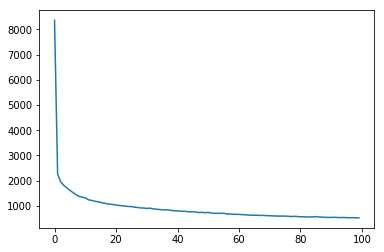

In [16]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [17]:
test_preds = []
first_batch = train_set[-n_inputs:]
current_batch = np.array(first_batch["Doses"]).reshape((1, n_inputs))

for i in range(len(test_set)):
    current_pred = model.predict(current_batch)[0]
    test_preds.append(current_pred[0])
    current_batch = np.append(current_batch[:, 1:], [current_pred], axis=1)

In [18]:
#true_preds = scaler.inverse_transform(test_preds)
test_set["Predictions"] = test_preds

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


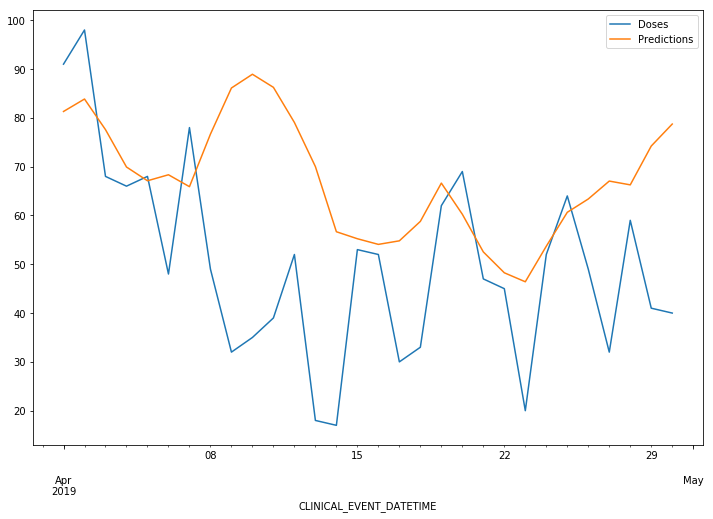

In [19]:
test_set.plot(figsize=(12, 8));

In [20]:
mse_rnn = mean_squared_error(test_set["Doses"], test_set["Predictions"])
rmse_rnn = rmse(test_set["Doses"],  test_set["Predictions"])

print(f'MSE RNN: {mse_rnn:11.10}')
print(f'RMSE RNN: {rmse_rnn:11.10}')

MSE RNN:   701.25371
RMSE RNN:  26.4811954


# Forecast

In [21]:
n_fcast = 60
new_preds = []
first_batch = df[-n_inputs:]
current_batch = np.array(first_batch["Doses"]).reshape((1, n_inputs))

for i in range(n_fcast):
    current_pred = model.predict(current_batch)[0]
    new_preds.append(current_pred[0])
    current_batch = np.append(current_batch[:, 1:], [current_pred], axis=1)

In [22]:
#unscaled_preds = scaler.inverse_transform(new_preds)
#undiff_preds = df_daily["Doses"].iloc[-1] + unscaled_preds.cumsum()
df_preds = pd.DataFrame(new_preds, columns=["Predictions"])
idx = pd.date_range(df_daily.index[-1] + 1, periods = n_fcast, freq="D")
df_preds.index = idx

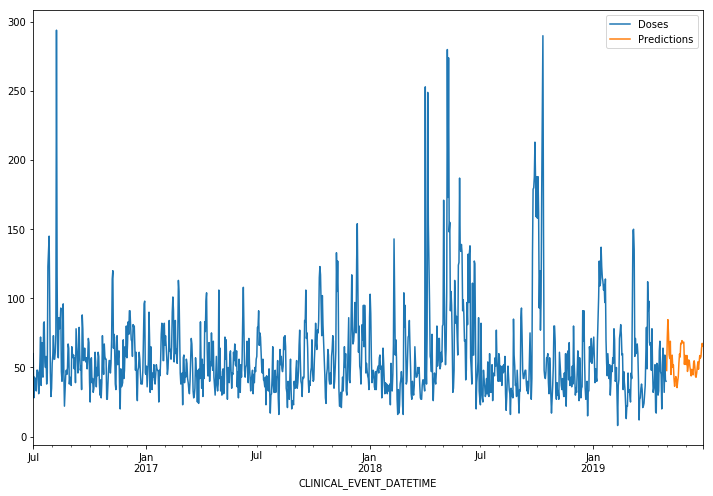

In [23]:
ax = df_daily["Doses"].plot(figsize=(12, 8), legend=True)
df_preds["Predictions"].plot(legend=True);
ax.autoscale(axis='x',tight=True)

In [46]:
#model.save("acetaminophen_mlp_2-layer.h5")